# Carregando bibliotecas

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix)
from scipy.stats import (randint, uniform)

# Analisando estrutura do dataset

In [3]:
bank = pd.read_csv('bank.csv', sep = ';')

bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
print(f'O dataset possui {bank.shape[0]} linhas e {bank.shape[1]} colunas')

O dataset possui 4521 linhas e 17 colunas


In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [6]:
bank['y'].value_counts(normalize = True)

y
no     0.88476
yes    0.11524
Name: proportion, dtype: float64

In [7]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


# Análise exploratória (EDA)

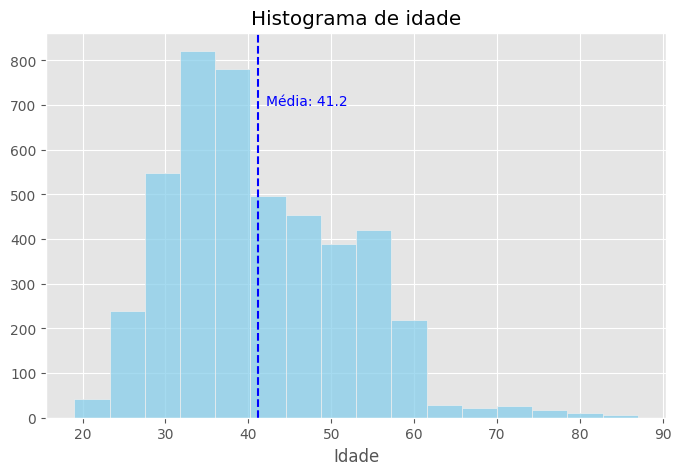

In [8]:
mean = np.mean(bank['age'])

plt.figure(figsize = (8, 5))

sns.histplot(x = 'age', bins = 16, data = bank, color = 'skyblue')
plt.title('Histograma de idade')
plt.xlabel('Idade')
plt.ylabel('')

plt.axvline(mean, color = 'blue', linestyle = '--', label = f'Média: {mean:.2f}')
plt.text(mean + 1, 700, f'Média: {mean:.1f}', color = 'blue', fontsize = 10)

plt.show()

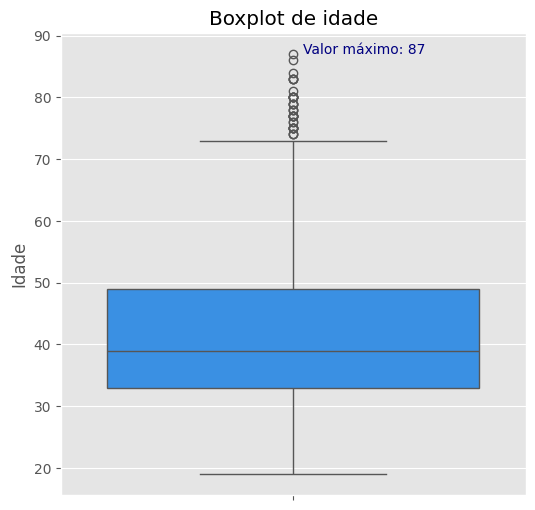

In [9]:
max = np.max(bank['age'])

plt.figure(figsize = (6, 6))

sns.boxplot(y = 'age', data = bank, color = 'dodgerblue')
plt.title('Boxplot de idade')
plt.xlabel('')
plt.ylabel('Idade')

plt.text(0.02, max, f'Valor máximo: {max}', color = 'navy', fontsize = 10)

plt.show()

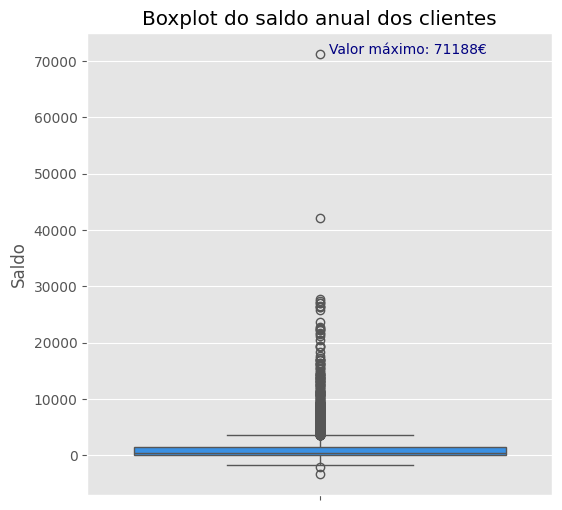

In [10]:
max = np.max(bank['balance'])

plt.figure(figsize = (6, 6))

sns.boxplot(y = 'balance', data = bank, color = 'dodgerblue')
plt.title('Boxplot do saldo anual dos clientes')
plt.xlabel('')
plt.ylabel('Saldo')

plt.text(0.02, max, f'Valor máximo: {max}€', color = 'navy', fontsize = 10)

plt.show()

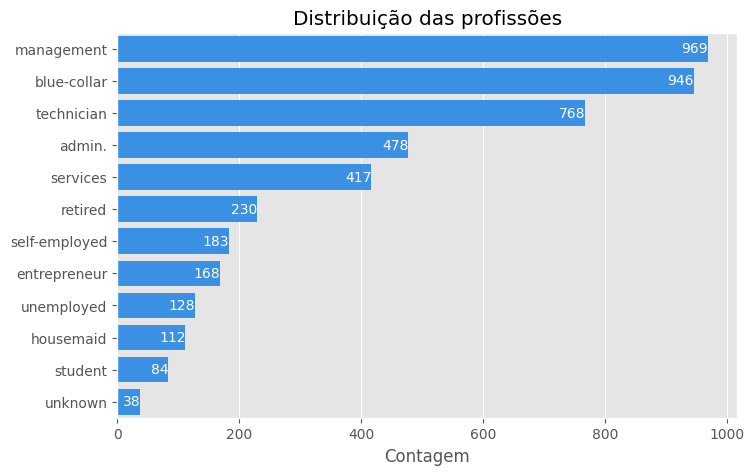

In [11]:
job_count = bank['job'].value_counts()

plt.figure(figsize = (8, 5))

sns.barplot(y = job_count.index, x = job_count.values, color = 'dodgerblue')
plt.title('Distribuição das profissões')
plt.xlabel('Contagem')
plt.ylabel('')

for i, v in enumerate(job_count.values):
    plt.text(v, i, str(v), ha = 'right', va = 'center', fontsize = 10, color = 'white')

plt.show()

Observamos que a maioria dos clientes está na faixa etária de 33 a 49 anos. Além disso, as profissões mais comuns entre eles são, respectivamente, management, blue-collar e technician.

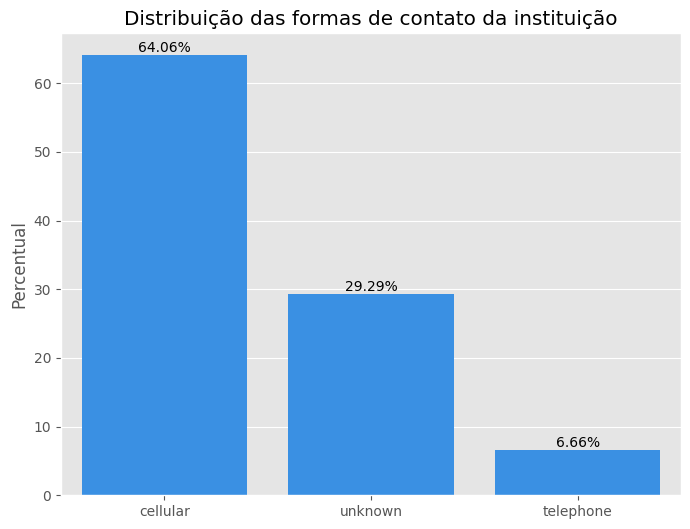

In [12]:
contact_percent = bank['contact'].value_counts(normalize = True) * 100

plt.figure(figsize = (8, 6))

sns.barplot(x = contact_percent.index, y = contact_percent.values, color = 'dodgerblue')
plt.title('Distribuição das formas de contato da instituição')
plt.xlabel('')
plt.ylabel('Percentual')

for i, v in enumerate(contact_percent.values):
    plt.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

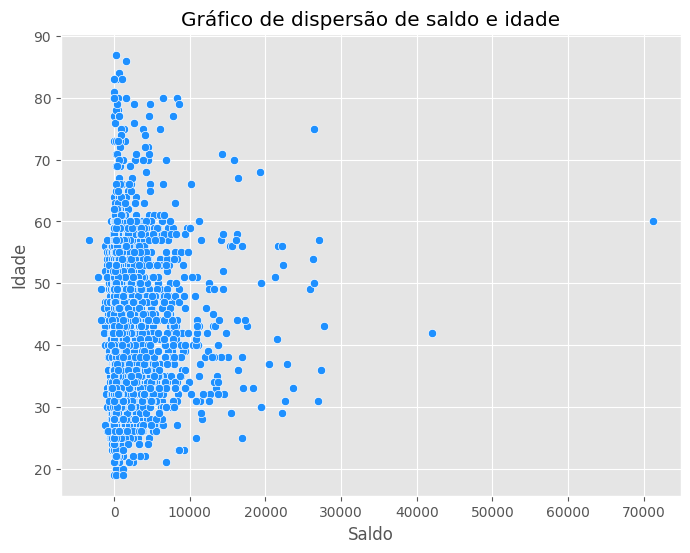

In [13]:
plt.figure(figsize = (8, 6))

sns.scatterplot(x = 'balance', y = 'age', data = bank, color = 'dodgerblue')
plt.title('Gráfico de dispersão de saldo e idade')
plt.xlabel('Saldo')
plt.ylabel('Idade')

plt.show()

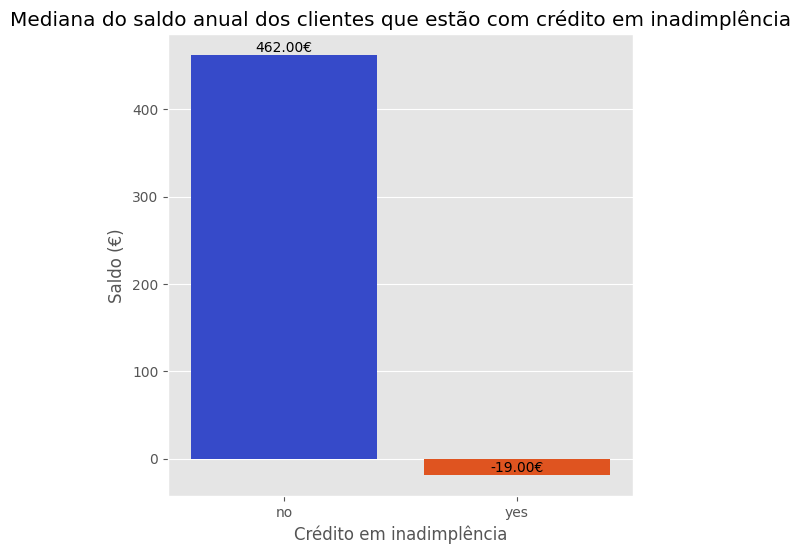

In [14]:
balance_default = bank.groupby('default')['balance'].median()
strong_palette = sns.color_palette(['#1D38E2', '#FF4500'])

plt.figure(figsize = (6, 6))

sns.barplot(x = balance_default.index, y = balance_default.values, palette = strong_palette)
plt.title('Mediana do saldo anual dos clientes que estão com crédito em inadimplência')
plt.xlabel('Crédito em inadimplência')
plt.ylabel('Saldo (€)')

for i, v in enumerate(balance_default.values):
    plt.text(i, v, f'{v:.2f}€', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

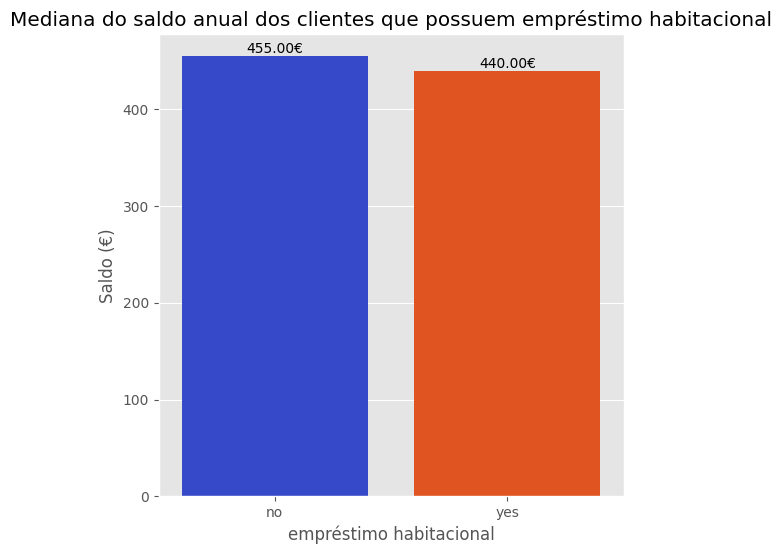

In [15]:
balance_housing = bank.groupby('housing')['balance'].median()

plt.figure(figsize = (6, 6))

sns.barplot(x = balance_housing.index, y = balance_housing.values, palette = strong_palette)
plt.title('Mediana do saldo anual dos clientes que possuem empréstimo habitacional')
plt.xlabel('empréstimo habitacional')
plt.ylabel('Saldo (€)')

for i, v in enumerate(balance_housing.values):
    plt.text(i, v, f'{v:.2f}€', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

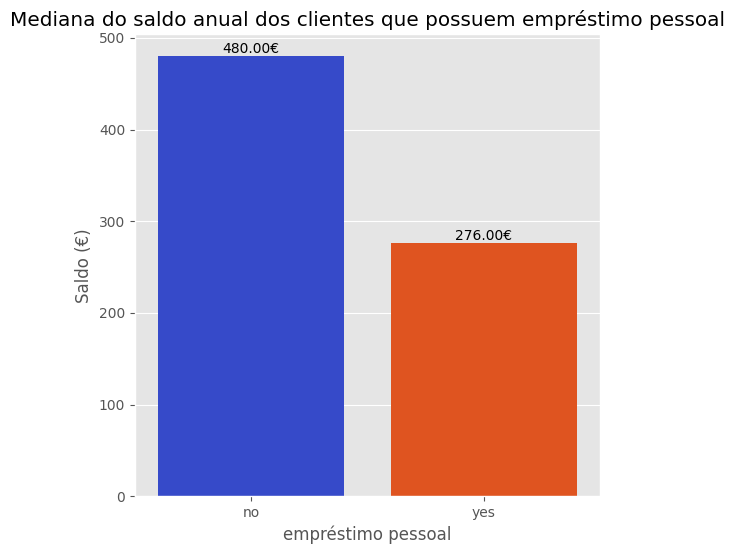

In [16]:
balance_loan = bank.groupby('loan')['balance'].median()

plt.figure(figsize = (6, 6))

sns.barplot(x = balance_loan.index, y = balance_loan.values, palette = strong_palette)
plt.title('Mediana do saldo anual dos clientes que possuem empréstimo pessoal')
plt.xlabel('empréstimo pessoal')
plt.ylabel('Saldo (€)')

for i, v in enumerate(balance_loan.values):
    plt.text(i, v, f'{v:.2f}€', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

Devido à presença de muitos outliers na coluna 'balance', optamos por usar a mediana como métrica central, já que a média seria fortemente influenciada pelos valores fora da curva. Observamos que mais de 50% das pessoas com crédito em inadimplência apresentam um saldo anual negativo. Além disso, a maioria dos clientes com empréstimos habitacionais possuem um saldo anual um pouco menor em comparação aos que não têm esse tipo de empréstimo. Por outro lado, a maioria dos clientes com empréstimos pessoais apresenta um saldo anual significativamente inferior em relação aqueles que não possuem esse tipo de empréstimo.

In [17]:
q1 = np.quantile(bank['balance'], 0.25)
q3 = np.quantile(bank['balance'], 0.75)

IQR = q3 - q1

lower_limit = q1 - 1.5 * IQR
upper_limit = q3 + 1.5 * IQR

outliers = bank[(bank['balance'] < lower_limit) | (bank['balance'] > upper_limit)]
no_outliers = bank[(bank['balance'] >= lower_limit) & (bank['balance'] <= upper_limit)]

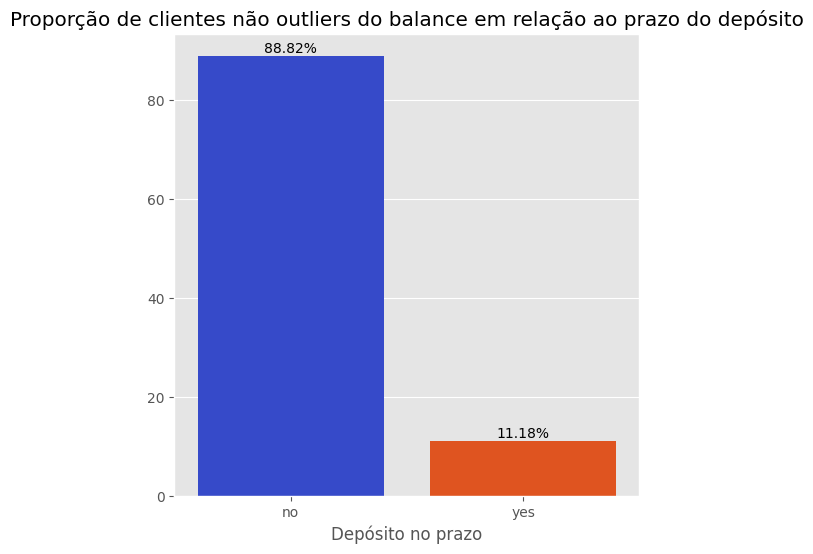

In [18]:
no_outliers_y_percent = no_outliers['y'].value_counts(normalize = True) * 100

plt.figure(figsize = (6, 6))

sns.barplot(x = no_outliers_y_percent.index, y = no_outliers_y_percent.values, palette = strong_palette)
plt.title('Proporção de clientes não outliers do balance em relação ao prazo do depósito')
plt.xlabel('Depósito no prazo')
plt.ylabel('')

for i, v in enumerate(no_outliers_y_percent.values):
    plt.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

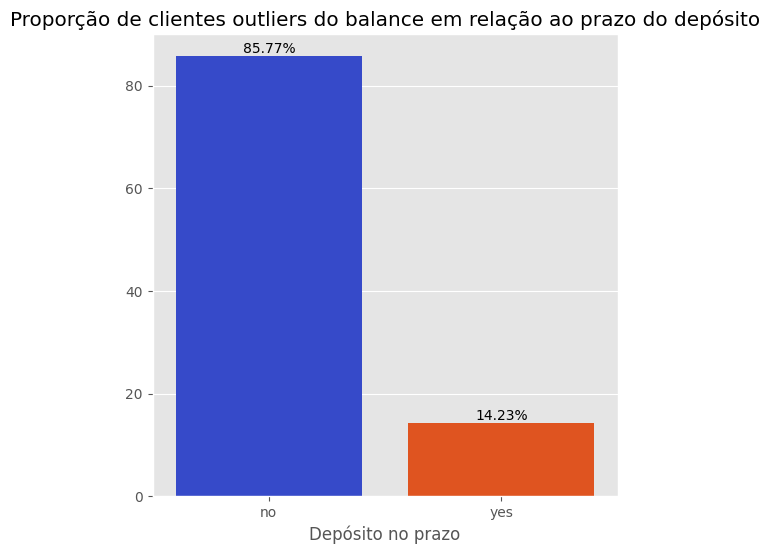

In [19]:
outliers_y_percent = outliers['y'].value_counts(normalize = True) * 100

plt.figure(figsize = (6, 6))

sns.barplot(x = outliers_y_percent.index, y = outliers_y_percent.values, palette = strong_palette)
plt.title('Proporção de clientes outliers do balance em relação ao prazo do depósito')
plt.xlabel('Depósito no prazo')
plt.ylabel('')

for i, v in enumerate(outliers_y_percent.values):
    plt.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

A análise que separa os clientes com saldo anual muito alto ou muito baixo (outliers) e compara a distribuição entre aqueles que subscreveram um depósito a prazo e os que não o cumpriram sugere que o saldo anual não é um fator determinante para prever atrasos nos depósitos. Isso ocorre porque as proporções de comportamento entre os clientes outliers e não outliers foram muito semelhantes.

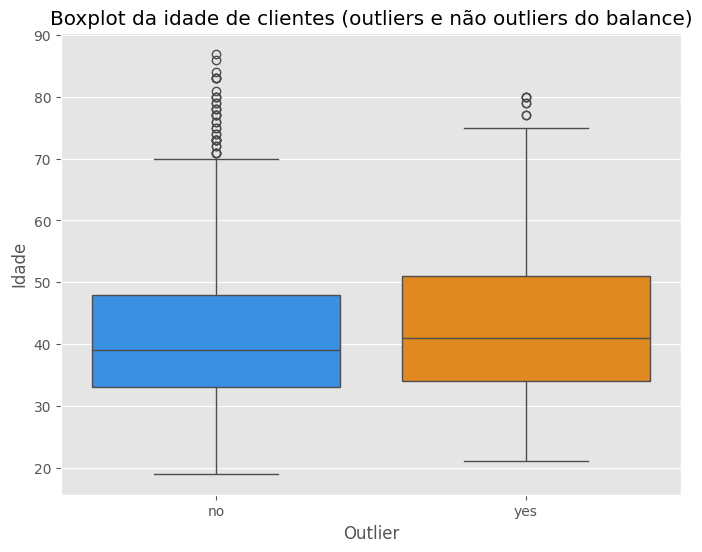

In [20]:
no_outliers['outliers'] = 'no'
outliers['outliers'] = 'yes'

df_combined = pd.concat([no_outliers, outliers])

plt.figure(figsize=(8, 6))

sns.boxplot(x = 'outliers', y = 'age', data = df_combined, palette = ['dodgerblue', '#FF8C00'])
plt.title('Boxplot da idade de clientes (outliers e não outliers do balance)')
plt.xlabel('Outlier')
plt.ylabel('Idade')

plt.show()

Observamos no gráfico que o primeiro e o terceiro quartil dos clientes outliers estão ligeiramente mais elevados, indicando que a maioria dos clientes com saldos anuais excessivamente altos ou baixos tende a ser composta por pessoas de faixas etárias um pouco mais avançadas.

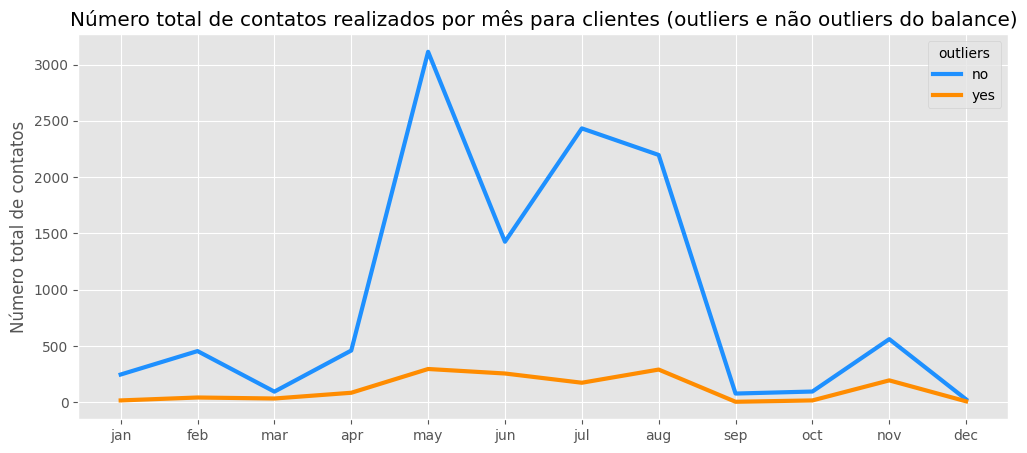

In [21]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df_combined['month'] = pd.Categorical(df_combined['month'], categories = month_order, ordered=True)

campaign_month = df_combined.groupby(['month', 'outliers'])['campaign'].sum().reset_index()

plt.figure(figsize = (12, 5))

sns.lineplot(x = 'month', y = 'campaign', hue = 'outliers', data = campaign_month, linewidth = 3, palette = ['dodgerblue', '#FF8C00'])
plt.title('Número total de contatos realizados por mês para clientes (outliers e não outliers do balance)')
plt.xlabel('')
plt.ylabel('Número total de contatos')

plt.show()

Pessoas que não tem seu saldo anual como outlier são feitos mais contatos pela instituição principalmente entre os meses de abril e setembro.

In [22]:
bank['y'] = bank['y'].replace({'no': 0, 'yes': 1})

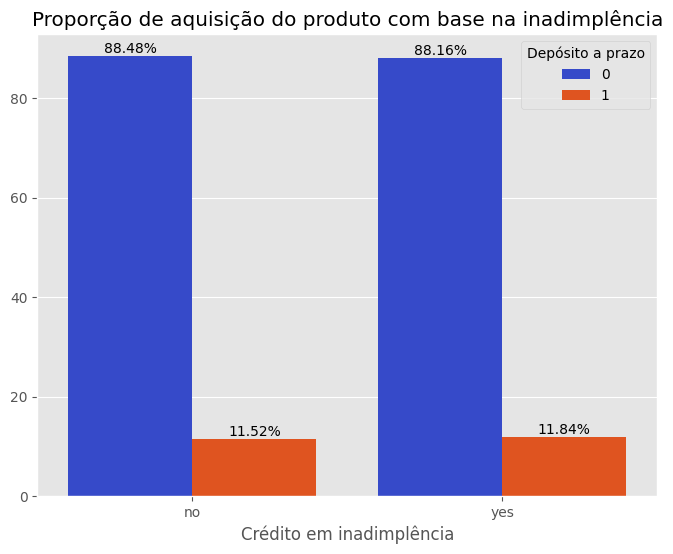

In [23]:
default_y_percent = bank.groupby('default')['y'].value_counts(normalize = True).reset_index(name = 'percentage')
default_y_percent['percentage'] = default_y_percent['percentage'] * 100

plt.figure(figsize = (8, 6))

sns.barplot(x = 'default', y = 'percentage', hue = 'y', data = default_y_percent, palette = strong_palette)
plt.title('Proporção de aquisição do produto com base na inadimplência')
plt.xlabel('Crédito em inadimplência')
plt.ylabel('')
plt.legend(title = 'Depósito a prazo')

for i, v in zip([-0.20, 0.20, 0.80, 1.20], default_y_percent['percentage']):
    plt.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

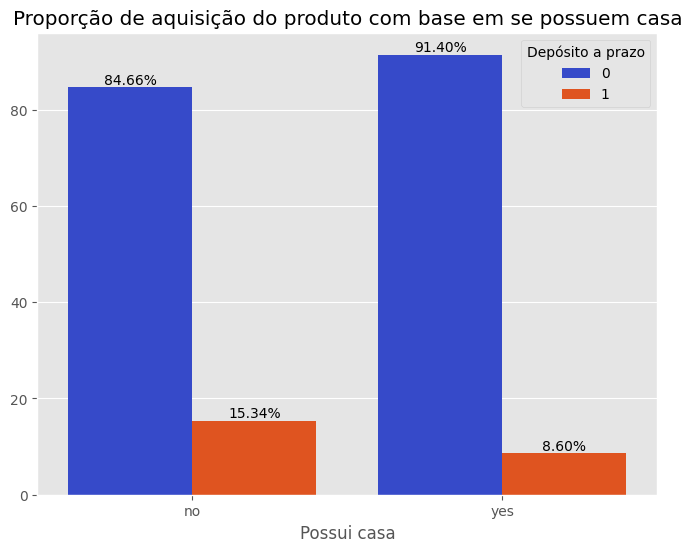

In [24]:
housing_y_percent = bank.groupby('housing')['y'].value_counts(normalize = True).reset_index(name = 'percentage')
housing_y_percent['percentage'] = housing_y_percent['percentage'] * 100

plt.figure(figsize = (8, 6))

sns.barplot(x = 'housing', y = 'percentage', hue = 'y', data = housing_y_percent, palette = strong_palette)
plt.title('Proporção de aquisição do produto com base em se possuem casa')
plt.xlabel('Possui casa')
plt.ylabel('')
plt.legend(title = 'Depósito a prazo')

for i, v in zip([-0.20, 0.20, 0.80, 1.20], housing_y_percent['percentage']):
    plt.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

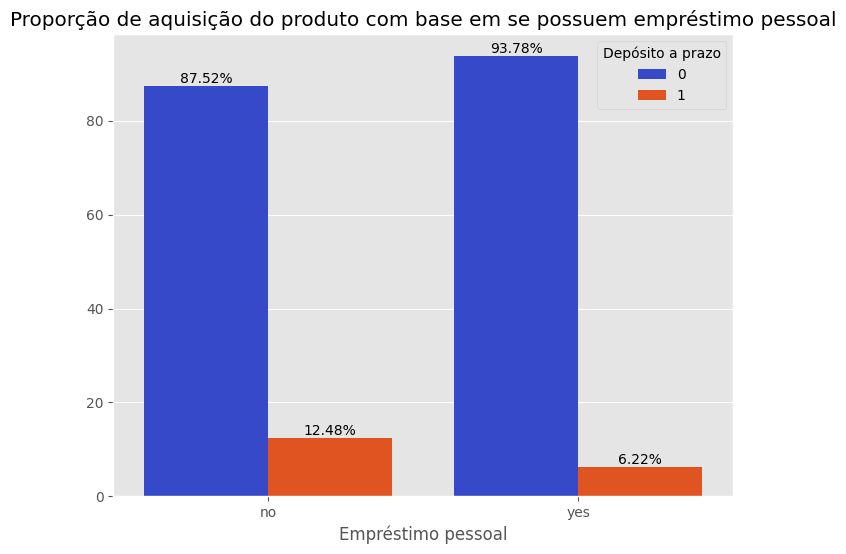

In [25]:
loan_y_percent = bank.groupby('loan')['y'].value_counts(normalize = True).reset_index(name = 'percentage')
loan_y_percent['percentage'] = loan_y_percent['percentage'] * 100

plt.figure(figsize = (8, 6))

sns.barplot(x = 'loan', y = 'percentage', hue = 'y', data = loan_y_percent, palette = strong_palette)
plt.title('Proporção de aquisição do produto com base em se possuem empréstimo pessoal')
plt.xlabel('Empréstimo pessoal')
plt.ylabel('')
plt.legend(title = 'Depósito a prazo')

for i, v in zip([-0.20, 0.20, 0.80, 1.20], loan_y_percent['percentage']):
    plt.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

Para nossos dados, vemos que, dentre os que não tomaram empréstimos, temos 12,48% adquirindo o produto, contra apenas 6,20% dentre os que tomaram empréstimos. Isso pode ser indício de que tomar empréstimos faça com que a pessoa não adquira o produto, provavelmente por já ter a renda comprometida. Curiosamente, o grupo de inadimplentes possuem a mesma proporção do grupo dos adimplentes.

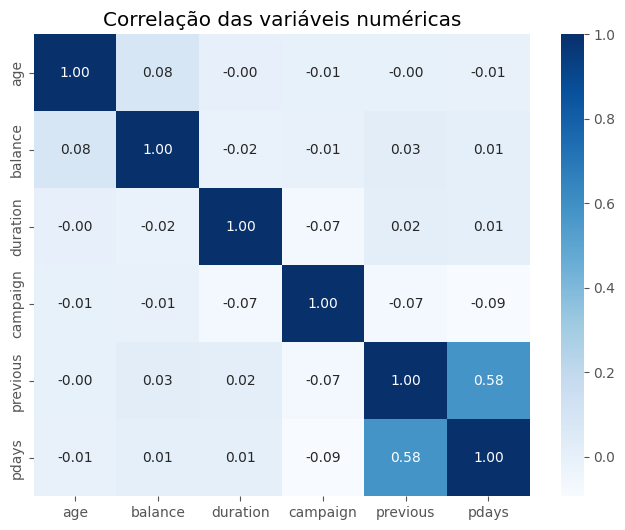

In [26]:
correlation_matrix = bank[['age', 'balance', 'duration', 'campaign', 'previous', 'pdays']].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues', fmt = '.2f')
plt.title('Correlação das variáveis numéricas')
plt.xlabel('')
plt.ylabel('')

plt.show()

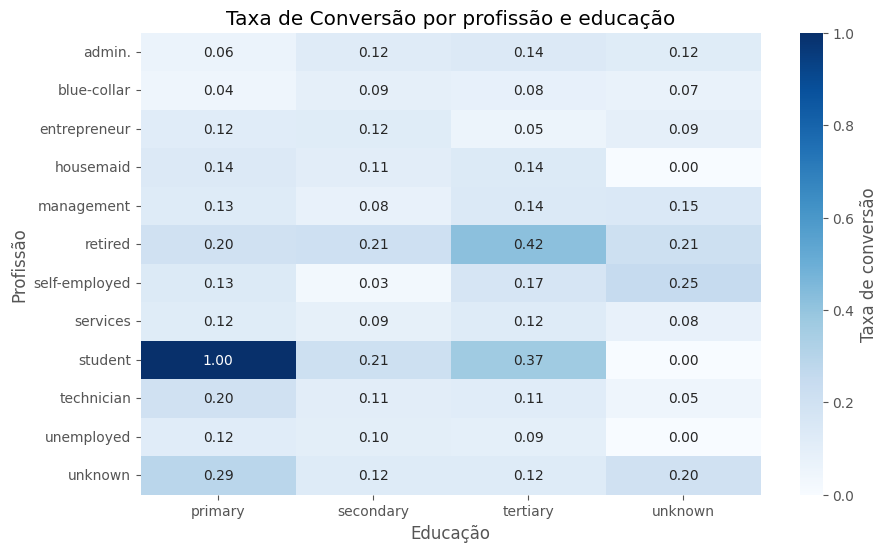

In [27]:
conversion_rate = bank.groupby(["job", "education"])["y"].mean().reset_index()
pivot_table = conversion_rate.pivot(index = "job", columns = "education", values = "y")

plt.figure(figsize = (10, 6))
sns.heatmap(pivot_table, annot = True, cmap = "Blues", fmt = ".2f", cbar_kws = {"label": "Taxa de conversão"})
plt.title("Taxa de Conversão por profissão e educação")
plt.xlabel("Educação")
plt.ylabel("Profissão")

plt.show()

Clientes com educação 'primary' tem uma taxa de conversão maior especialmente quando são da profissão 'student' e 'unknown', indicando que campanhas voltadas para esse público poderiam ser mais eficazes. O segundo grupo com maior taxa de conversão são os que possuem a educação 'tertiary' especialmente quando são das profissões 'retired' e 'student'. O grupo com a pior taxa de conversão seria os que possuem a educação 'unknown' isso pode indicar que este segmento é menos receptivo às ofertas de depósitos a prazo. As profissões com a maior taxa de conversão seriam: 'retired', 'student' e 'unknown'.

Vamos utilizar agora um conceito de probabilidade condicional, assumindo que um evento afeta o outro. Vamos verificar qual a probabilidade de um cliente adquirir o depósito bancário, dado que já entraram em contato com ele (coluna “previous” > 0).

Primeiro vamos entender os eventos envolvidos:
- Evento A: Cliente adquiriu um depósito (y = 'yes').
- Evento B: Cliente já foi contatado anteriormente (previous > 0).

Agora vamos usar a fórmula da probabilidade condicional: $$P(A|B)=\frac{P(A\cap B)}{P(B)}$$

In [28]:
lines_A_and_B = bank[(bank['y'] == 1) & (bank['previous'] > 0)].shape[0]
A_and_B = lines_A_and_B / bank.shape[0]

lines_B = bank[bank['previous'] > 0].shape[0]
B = lines_B / bank.shape[0]

prob_A_intersection_B = (A_and_B / B) * 100

print(f'Portanto a probabilidade do cliente adquirir um depósito dado que ele já foi contatado anteriormente é de {prob_A_intersection_B:.2f}%')

Portanto a probabilidade do cliente adquirir um depósito dado que ele já foi contatado anteriormente é de 22.55%


Por curiosidade vamos calcular a probabilidade da pessoa adquirir o depósito, dado que não houve contato prévio

In [29]:
lines_A_and_B = bank[(bank['y'] == 1) & (bank['previous'] == 0)].shape[0]
A_and_B = lines_A_and_B / bank.shape[0]

lines_B = bank[bank['previous'] == 0].shape[0]
B = lines_B / bank.shape[0]

prob_A_intersection_B = (A_and_B / B) * 100

print(f'Portanto a probabilidade do cliente adquirir um depósito dado que não houve contato prévio é de {prob_A_intersection_B:.2f}%')

Portanto a probabilidade do cliente adquirir um depósito dado que não houve contato prévio é de 9.10%


# Modelo preditivo

In [30]:
X = bank[['age', 'job', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome']]
y = bank['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [31]:
print(f'Shape do X_train: {X_train.shape}')
print(f'Shape do X_test: {X_test.shape}')

Shape do X_train: (3616, 14)
Shape do X_test: (905, 14)


In [32]:
numerical_features = ['age', 'balance', 'pdays', 'previous']

categorical_features = ['job', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [33]:
numerical_transformer = Pipeline(steps =[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps =[
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

RF = RandomForestClassifier()

pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', RF)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'education',
                                                   'default', 'housing', 'loan',
                                                   'contact', 'month',
                                                   'poutcome'])])),
                ('model', RandomForestClassifier())])

In [34]:
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       801
           1       0.50      0.19      0.28       104

    accuracy                           0.89       905
   macro avg       0.70      0.58      0.61       905
weighted avg       0.86      0.89      0.86       905



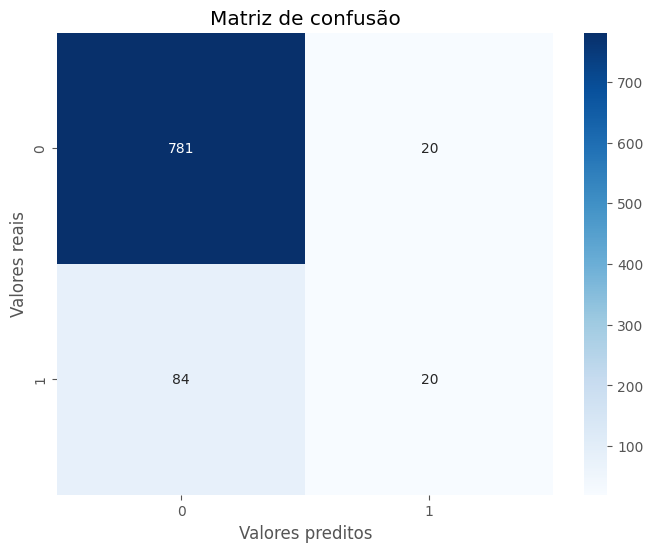

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = pipe.classes_, yticklabels = pipe.classes_)
plt.xlabel('Valores preditos')
plt.ylabel('Valores reais')
plt.title('Matriz de confusão')

plt.show()

In [36]:
param_dist = {
    'model__n_estimators': randint(50, 200),
    'model__max_depth': randint(3, 10),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__bootstrap': [True, False],
}

random_search = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'balance',
                                                                                'pdays',
                                                                                'previous']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['job',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome'])])),
                                             ('model',
                                              RandomForestClassif...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019C431989D0>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019C42F7FFD0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019C429C0760>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [37]:
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'education',
                                                   'default', 'housing', 'loan',
                                                   'contact', 'month',
                                                   'poutcome'])])),
                ('model',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=5,
                                        min_samples_split=5,
                                        n_estimators=117))])

In [38]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       801
           1       0.76      0.12      0.21       104

    accuracy                           0.90       905
   macro avg       0.83      0.56      0.58       905
weighted avg       0.88      0.90      0.86       905



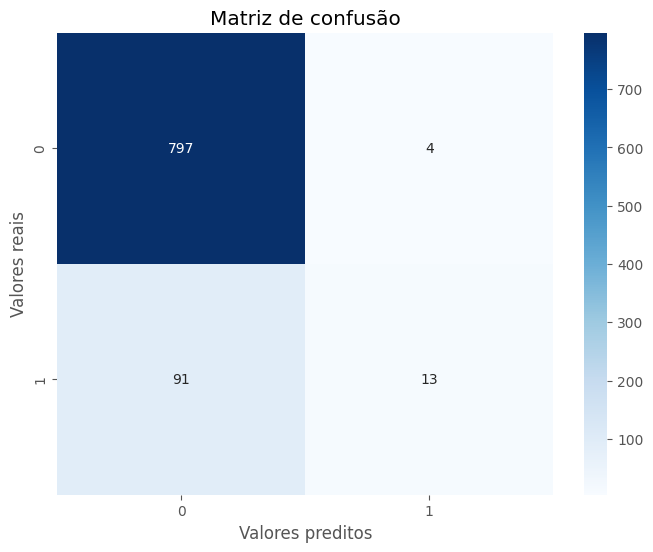

In [39]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = pipe.classes_, yticklabels = pipe.classes_)
plt.xlabel('Valores preditos')
plt.ylabel('Valores reais')
plt.title('Matriz de confusão')

plt.show()

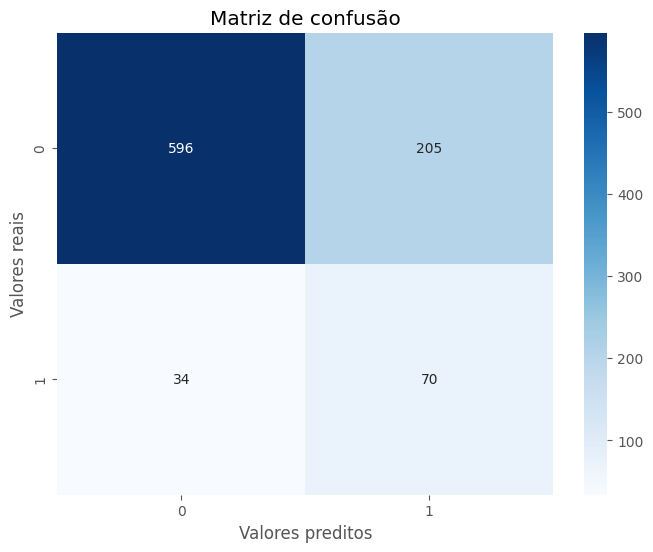

In [40]:
y_proba = best_model.predict_proba(X_test)[:, 1]

y_pred_adjusted = (y_proba >= 0.11).astype(int)

cm = confusion_matrix(y_test, y_pred_adjusted)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = pipe.classes_, yticklabels = pipe.classes_)
plt.xlabel('Valores preditos')
plt.ylabel('Valores reais')
plt.title('Matriz de confusão')

plt.show()

Inicialmente, o modelo teve um bom desempenho ao prever a classe 0, mas apresentou um desempenho ruim na previsão da classe 1. Tentamos ajustar os parâmetros do modelo para melhorar esse desempenho, mas não obtemos resultados satisfatórios. Como alternativa, manipulamos a probabilidade do modelo utilizando o método 'predict_proba', o que melhorou consideravelmente a previsão dos 1s, embora também tenha aumentado os erros nos 0s. Este é um ponto importante para discussão, pois é necessário avaliar qual modelo é mais adequado, considerando os objetivos do projeto e da empresa.